## Info
- Title: F1 Analysis
- Team: Accelerated Analytics
 
- Name: Siddharth Mehta

# QAC Report
## Questions
1) How similar is driver style based on their circumnstantial factors (weather, tyres, practice timings, circuit geography, speed, driver measurements, team funding, race laps, pit performance, time of day, type of circuit, etc)? Specifically, are there some drivers that are more similar to others, and why?

2) How much do circumstantial factors (weather, tyres, practice timings, circuit geography, speed, driver measurements, team funding, race laps, pit performance, time of day, type of circuit, etc) affect a driver's pace? Specifically, are there factors, or combinations of factors, that can normalize or change the playing field in competition?

#### Motivation
There are common beliefs in Formula 1 about how much circumnstantial factors affect ending position of a car, as well as that the car is at times, more important than the driver. Some also think that each driver could win in the championship-winning car; however each driver has a different style, with some being similar to others. Telemetry, weather, performance, and circuit data can possibly lead us to a definitive answer.

#### Methods
*For Question 1*

Distance Calculations
- Euclidean Distance
- Manhattan Distance

Dimension Reduction
- Multi-Dimentional Scaling (MDS)
- Principal Component Analysis (PCA)

Clustering
- Density-Based Clustering (DBC)
- K-Means Clustering (K-M)

Classification
- Decision Tree Classification (DTC)

*For Question 2*

Regression
- Robust Linear

In [40]:
# FastF1 imports
import fastf1 as ff1
import fastf1.plotting as f1plot

# Plotting imports
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
from matplotlib.pyplot import figure
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

# Dataframe and statistics imports
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
from sklearn.metrics import pairwise, confusion_matrix, classification_report
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Datetime imports
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

# FastF1 data cache
ff1.Cache.enable_cache('/Users/siddharth/Downloads/School Stuff/CMDA_3654/Project/F1-Cache')
import json
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_json'):
            return obj.to_json(orient='records')
        return json.JSONEncoder.default(self, obj)

<ipython-input-40-7c278ca9d56e>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Analysis

### Data
Data is sourced from the FastF1 (https://theoehrly.github.io/Fast-F1/) library. The previous five years (2018-2022) of race data will be used here. For the sake of computational simplicity, I will analyze only six drivers: Hamilton, Vettel, Alonso, Perez, Ricciardo, and Bottas. All of these drivers have been on the grid for at least the past five years. The past five years were chosen because of the level of regulation changes that evened the playing field during that time period.

In [76]:
# Setting up driver list and dataframe dictionary
# ONLY RUN ONCE -- afterwards saved in csv files to be pulled from

drivers = ['HAM','VET','VER','PER','RIC','BOT']
driverdict = {
    'HAM':[],
    'VET':[],
    'VER':[],
    'PER':[],
    'RIC':[],
    'BOT':[]
}

In [ ]:
# Pulling data from cache for each driver, their information, telemetry, and weather conditions
# ONLY RUN ONCE -- afterwards saved in csv files to be pulled from

for driver in drivers:
    finaldfs = []
    for i in range(2018,2023):
        for j in range(1,23):
            try:
                session = ff1.get_session(i, j, 'R')
                session.load()
                driv = session.laps.pick_driver(driver)

                base = driv[['Time','LapNumber','Compound','TyreLife']]
                base['SessionTimeSeconds'] = [st.seconds for st in base.Time]
                base.rename(columns={'Time':'SessionTime'}, inplace=True)

                try:
                    tel = driv.pick_accurate().get_telemetry()
                except:
                    continue
                tel = tel.where(tel['Speed'] > 0.0).dropna()

                telcar = pd.merge(driv.pick_accurate().get_car_data(), tel, on='SessionTime', how='inner')
                for col in telcar.columns:
                    if col[-1:]=='y':
                        telcar.drop(col, axis=1, inplace=True)
                weath = driv.pick_accurate().get_weather_data()
                weath.rename(columns={'Time':'SessionTime'}, inplace=True)

                telcar['SessionTimeSeconds'] = [st.seconds for st in telcar.SessionTime]
                weath['SessionTimeSeconds'] = [st.seconds for st in weath.SessionTime]

                final = pd.merge(telcar, base, on='SessionTimeSeconds', how='outer').fillna(method='ffill').dropna()
                final = pd.merge(final, weath, on='SessionTimeSeconds', how='outer').fillna(method='ffill').dropna()

                final['Compound'] = [1 if c=='SOFT' else 2 if c=='MEDIUM' else 3 for c in final.Compound]
                final['DriverAhead'] = [1 if d!='' else 0 for d in final.DriverAhead]
                final['Brake_x'] = [1 if b==True else 0 for b in final.Brake_x]
                final['Rainfall'] = [1 if r==True else 0 for r in final.Rainfall]
                final = final[['Speed_x', 'RPM_x', 'DRS_x', 'DriverAhead', 'DistanceToDriverAhead', 'LapNumber',
                               'Compound', 'TyreLife','X', 'Y', 'Z', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                               'TrackTemp', 'WindDirection', 'WindSpeed']]
                finaldfs.append(final)
            except ValueError:
                continue
    final = pd.concat([df for df in finaldfs])
    driverdict[driver] = final

In [43]:
# Saving dictionary to JSON and dataframes to CSV

with open('ProjectData.json', 'w') as fp:
    json.dump(driverdict, fp, cls=JSONEncoder)
driverdict['HAM'].to_csv('hamdf.csv')
driverdict['VET'].to_csv('vetdf.csv')
driverdict['VER'].to_csv('verdf.csv')
driverdict['PER'].to_csv('perdf.csv')
driverdict['RIC'].to_csv('ricdf.csv')
driverdict['BOT'].to_csv('botdf.csv')

### Data Cleaning and Processing

After importing the data, we need to add a 'Driver' column to each dataframe, and then make that the index for any distance calculations. We also need a single, concatenated dataframe for any regression calculations.

In [77]:
# RUN THIS INSTEAD OF PREVIOUS THREE CELLS

# Setting up driver list and dataframe dictionary
drivers = ['HAM','VET','VER','PER','RIC','BOT']

driverdict = {
    'HAM':pd.read_csv('hamdf.csv').drop('Unnamed: 0', axis=1),
    'VET':pd.read_csv('vetdf.csv').drop('Unnamed: 0', axis=1),
    'VER':pd.read_csv('verdf.csv').drop('Unnamed: 0', axis=1),
    'PER':pd.read_csv('perdf.csv').drop('Unnamed: 0', axis=1),
    'RIC':pd.read_csv('ricdf.csv').drop('Unnamed: 0', axis=1),
    'BOT':pd.read_csv('botdf.csv').drop('Unnamed: 0', axis=1),
}

# Adding driver name column to each dictionary
for driver in drivers:
    driverdict[driver]['Driver'] = [driver for i in range(0,len(driverdict[driver].index))]
    
# Concatenating all dataframes into single dataframe for future use
data = pd.concat(list(driverdict.values()))#.reset_index().drop('index', axis=1)
data.index = data.Driver
data.drop('Driver', axis=1, inplace=True)

#### Distance and Dimension Reduction

Since each driver has over 100,000 rows, we will use the median of each driver's statistics for the distance calculations

In [78]:
dfForDist = {}
for driver in drivers:
    dfForDist[driver] = driverdict[driver].describe().loc['50%']
dfForDist = pd.DataFrame(dfForDist).drop('Speed_x', axis=0).transpose()

distHD = pairwise.euclidean_distances(dfForDist)
distHD = pd.DataFrame(distHD, columns=dfForDist.index, index=dfForDist.index )
distHD

HAM         VET         VER         PER         RIC         BOT
HAM    0.000000   81.965794  172.150962  253.352936  145.131623  159.514975
VET   81.965794    0.000000  187.194465  205.558120  195.707451  205.029737
VER  172.150962  187.194465    0.000000  250.856733  141.232873  171.256788
PER  253.352936  205.558120  250.856733    0.000000  299.764091  281.323215
RIC  145.131623  195.707451  141.232873  299.764091    0.000000   61.155318
BOT  159.514975  205.029737  171.256788  281.323215   61.155318    0.000000

We will employ multi-dimensional scaling in both two and three dimensions, in order to glean the most information possible in a visual format.

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


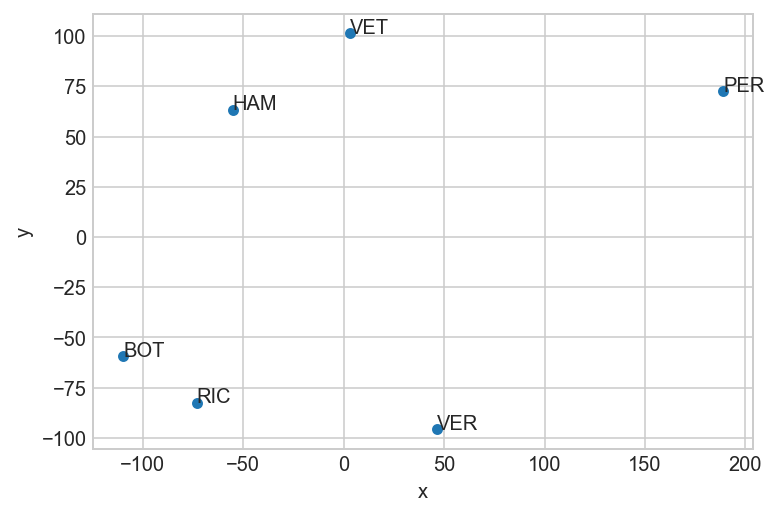

In [79]:
mds = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, n_init=100)
data2D = mds.fit_transform(distHD)
data2D = pd.DataFrame(data2D, columns=['x', 'y'], index=dfForDist.index)

ax = data2D.plot.scatter('x', 'y')
ax.axis('scaled')
for i, r in data2D.iterrows():
    ax.text(r.x, r.y, i)

Interestingly, Hamilton and Vettel seem to very close, even though they performed drastically different throughout each season. Bottas, Ricciardo, and Verstappen also have this similarity, despite having the same difference. Perez is actually closer to Vettel and Hamilton than Verstappen.

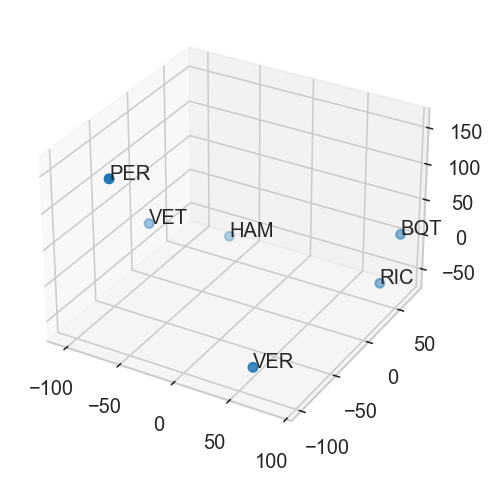

In [80]:
mds = MDS(n_components=3, dissimilarity='precomputed', max_iter=1000, n_init=100)
data2D = mds.fit_transform(distHD)
data2D = pd.DataFrame(data2D, columns=['x', 'y', 'z'], index=dfForDist.index)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data2D.x, data2D.y, data2D.z)
for i, r in data2D.iterrows():
    ax.text(r.x, r.y, r.z, i)

If we use three components, Verstappen is the clear outlier, while Hamilton and Vettel remain close and Perez moves closer. The most significant change here is how Ricciardo and Bottas are now closer to Hamilton and Vettel.

In [81]:
pca = PCA()
tablePCA = pca.fit_transform(dfForDist)
tablePCA = pd.DataFrame(tablePCA, index = dfForDist.index)
tablePCA

0          1          2          3          4             5
HAM  -17.649061  85.342442  -0.035617  22.958382   2.799425  1.033827e-13
VET   50.814309  88.870191  10.409257 -20.140927  -4.416355  1.033827e-13
VER  -28.699453 -55.789521  95.634363   2.849416  -3.405094  1.033827e-13
PER  190.295294 -55.515872 -26.549308   2.889518   3.035048  1.033827e-13
RIC -106.976500 -22.474617 -15.217121 -10.912788  11.829599  1.033827e-13
BOT  -87.784589 -40.432623 -64.241574   2.356399  -9.842623  1.033827e-13

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


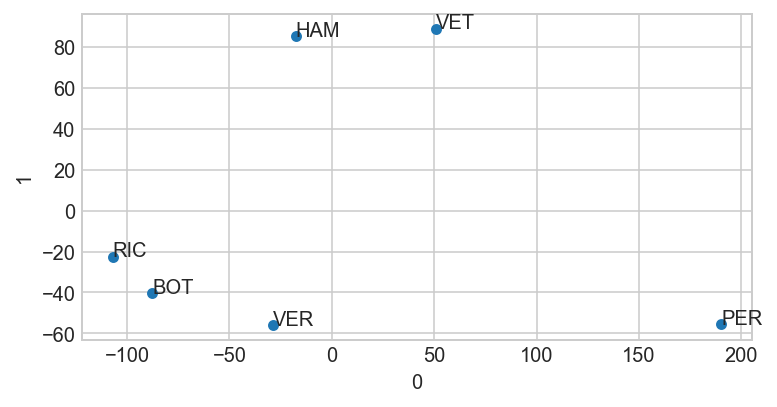

In [82]:
ax = tablePCA.plot.scatter(0, 1)
ax.axis('scaled')
for i, r in tablePCA.iterrows():
    ax.text(r[0], r[1], i)

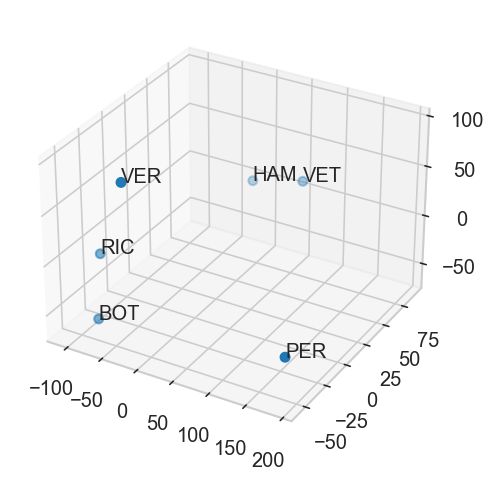

In [83]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(tablePCA[0], tablePCA[1], tablePCA[2])
for i, r in tablePCA.iterrows():
    ax.text(r[0], r[1], r[2], i)

Based on the previous two graphs, we can see that Verstappen, Ricciardo, and Bottas are now surprisingly close, while Hamilton and Vettel get even closer and Perez is a clear outlier.

<BarContainer object of 6 artists>

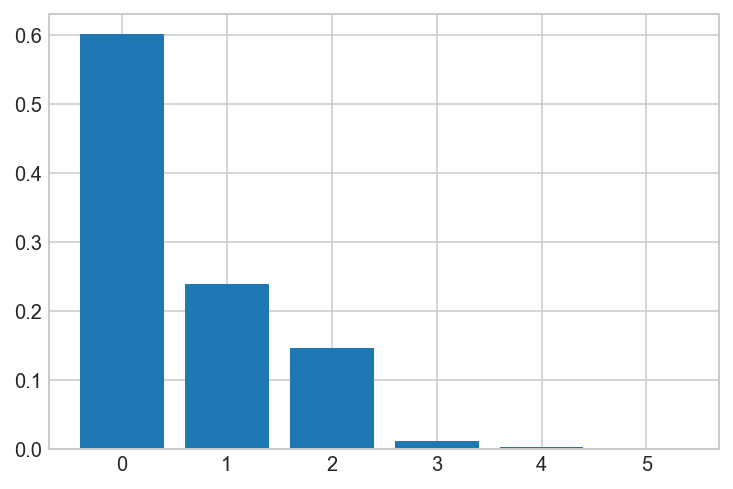

In [84]:
plt.bar(tablePCA.columns, pca.explained_variance_ratio_)

#### K-Means Clustering

We will employ K-Means clustering in order to determine whether our dimension reduction was indeed yielding correct results. We will utilize K=2, K=3, and K=4 due to the limited number of labels.

In [148]:
kmclusters = {
    2:[],
    3:[],
    4:[],
}
kmcenters = {
    2:[],
    3:[],
    4:[],
}

for key in kmclusters.keys():
    for i in range(0,4):
        km = KMeans(n_clusters=key)
        labels = km.fit_predict(tablePCA)
        labels = pd.DataFrame(labels, columns=['Cluster'], index=tablePCA.index)
        kmclusters[key].append(tablePCA.copy().join(labels).sort_values('Cluster'))
        kmcenters[key].append(pd.DataFrame(km.cluster_centers_, columns=tablePCA.columns))

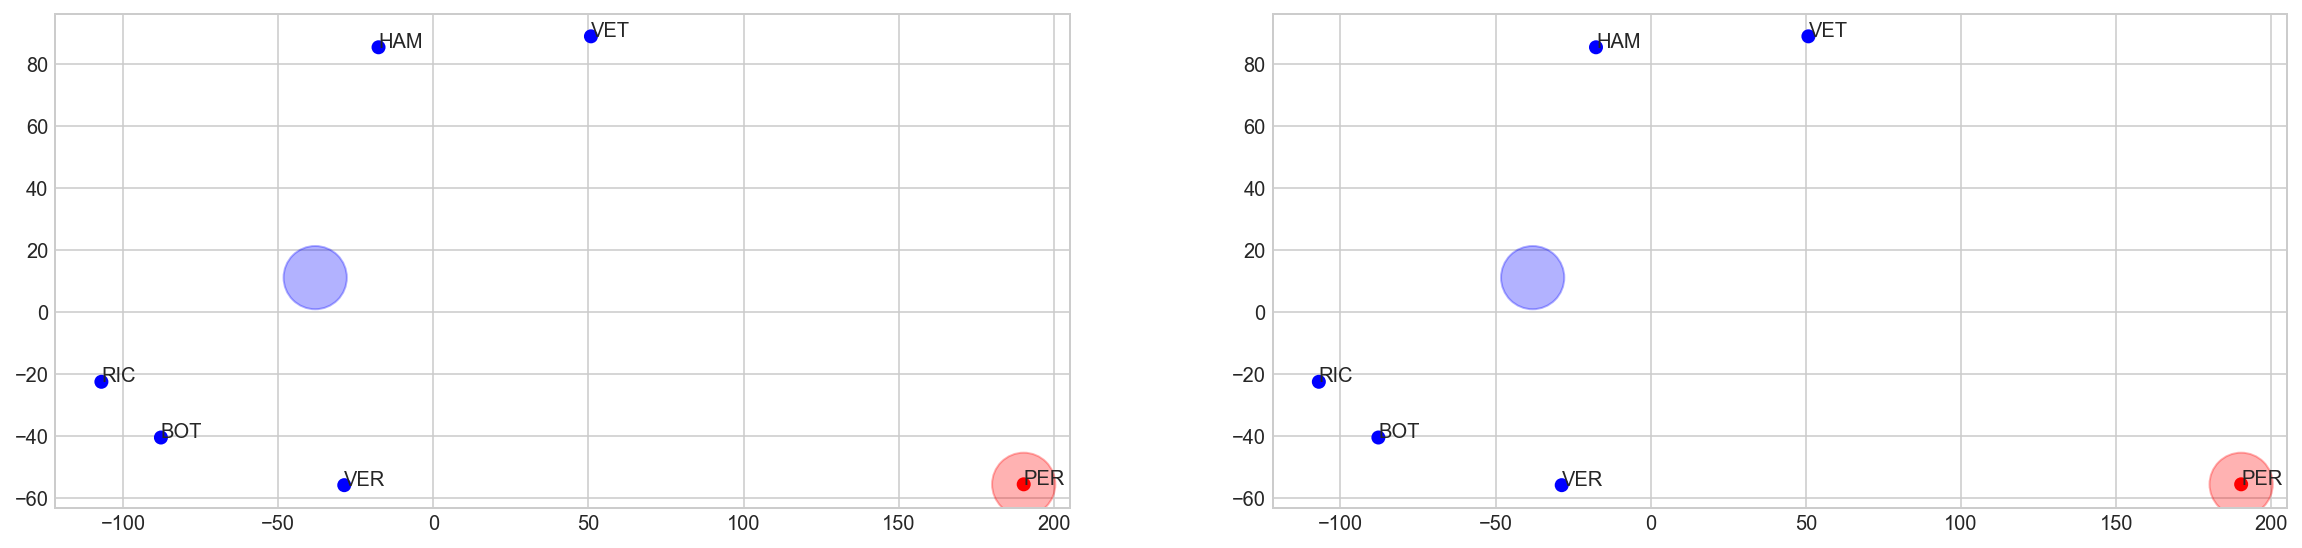

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].scatter(kmclusters[2][0][0], kmclusters[2][0][1], c=kmclusters[2][0].Cluster.map({0:'red',1:'blue'}))
ax[0].axis('scaled')
[ax[0].text(r[0], r[1], i) for (i,r) in tablePCA.iterrows()]
ax[0].scatter(kmcenters[2][0][0], kmcenters[2][0][1], s=1000, alpha=0.3, 
              c=kmcenters[2][0].index.map({0:'red',1:'blue'}))
ax[1].scatter(kmclusters[2][1][0], kmclusters[2][1][1], c=kmclusters[2][1].Cluster.map({0:'red',1:'blue'}))
ax[1].axis('scaled')
[ax[1].text(r[0], r[1], i) for (i,r) in tablePCA.iterrows()]
ax[1].scatter(kmcenters[2][1][0], kmcenters[2][1][1], s=1000, alpha=0.3, 
              c=kmcenters[2][1].index.map({0:'red',1:'blue'}))
None

We can clearly see here that using two clusters is unhelpful, as it singles out the outlier and puts the rest of the values in the other cluster.

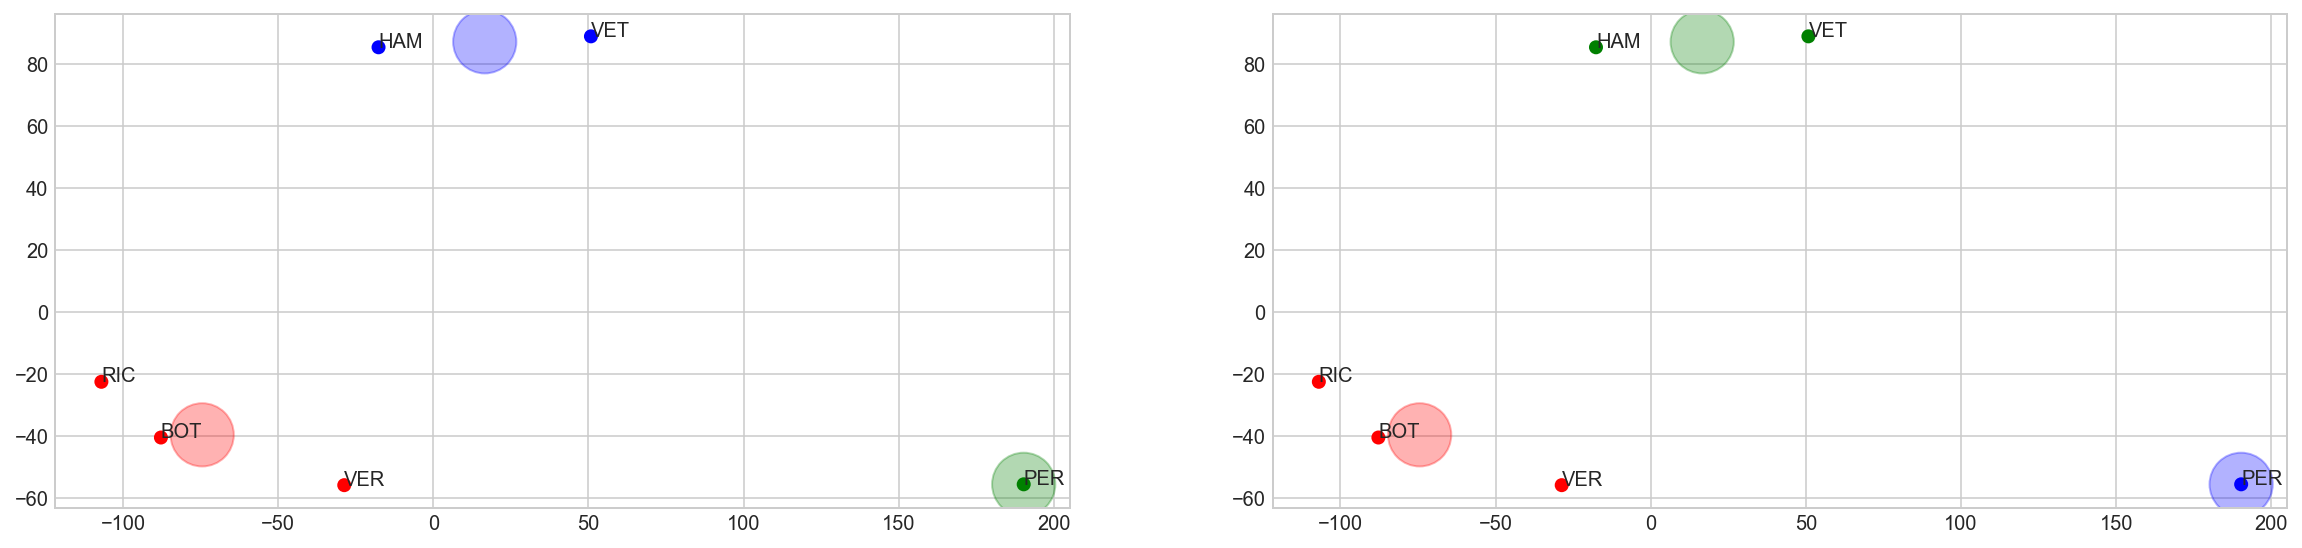

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].scatter(kmclusters[3][0][0], kmclusters[3][0][1], c=kmclusters[3][0].Cluster.map({0:'red',1:'blue',2:'green'}))
ax[0].axis('scaled')
[ax[0].text(r[0], r[1], i) for (i,r) in tablePCA.iterrows()]
ax[0].scatter(kmcenters[3][0][0], kmcenters[3][0][1], s=1000, alpha=0.3, 
              c=kmcenters[3][0].index.map({0:'red',1:'blue',2:'green'}))
ax[1].scatter(kmclusters[3][1][0], kmclusters[3][1][1], c=kmclusters[3][1].Cluster.map({0:'red',1:'blue',2:'green'}))
ax[1].axis('scaled')
[ax[1].text(r[0], r[1], i) for (i,r) in tablePCA.iterrows()]
ax[1].scatter(kmcenters[3][1][0], kmcenters[3][1][1], s=1000, alpha=0.3, 
              c=kmcenters[3][1].index.map({0:'red',1:'blue',2:'green'}))
None

Here we can clearly confirm what we thought we had seen earlier, where the Hamilton and Vettel are close while Perez sits as an outlier and Ricciardo, Bottas, and Verstappen form another cluster.

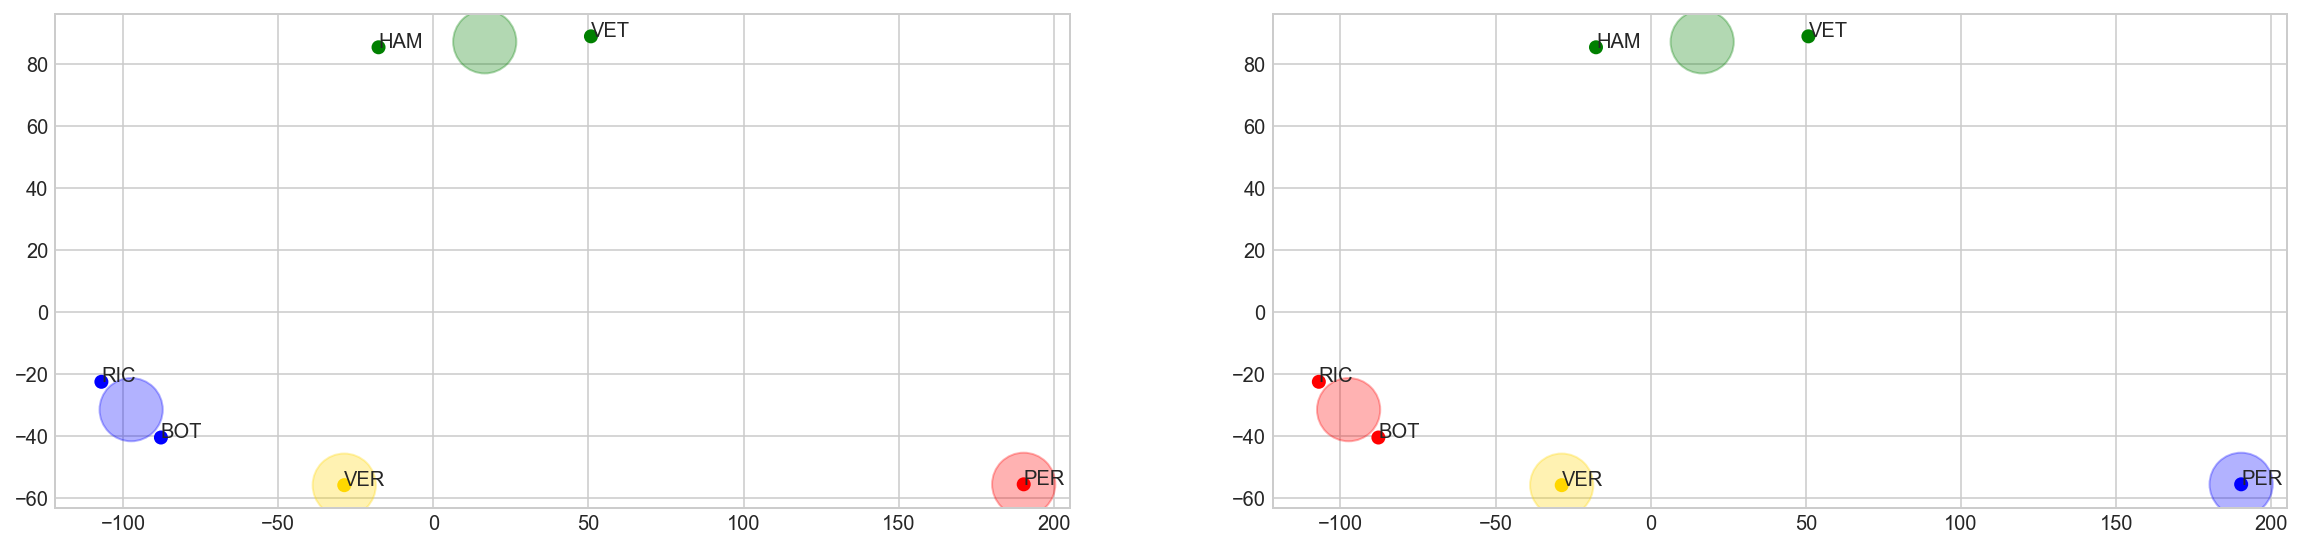

In [166]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].scatter(kmclusters[4][0][0], kmclusters[4][0][1], 
              c=kmclusters[4][0].Cluster.map({0:'red',1:'blue',2:'green',3:'gold'}))
ax[0].axis('scaled')
[ax[0].text(r[0], r[1], i) for (i,r) in tablePCA.iterrows()]
ax[0].scatter(kmcenters[4][0][0], kmcenters[4][0][1], s=1000, alpha=0.3, 
              c=kmcenters[4][0].index.map({0:'red',1:'blue',2:'green',3:'gold'}))
ax[1].scatter(kmclusters[4][1][0], kmclusters[4][1][1], 
              c=kmclusters[4][1].Cluster.map({0:'red',1:'blue',2:'green',3:'gold'}))
ax[1].axis('scaled')
[ax[1].text(r[0], r[1], i) for (i,r) in tablePCA.iterrows()]
ax[1].scatter(kmcenters[4][1][0], kmcenters[4][1][1], s=1000, alpha=0.3, 
              c=kmcenters[4][1].index.map({0:'red',1:'blue',2:'green',3:'gold'}))
None

The thought behind using four clusters was that Perhaps Verstappen and Perez were close enough at higher dimensions to warrant them being in a cluster, however this was not the case.

#### Robust Linear Regression

We will be running this regression to see which type of circumnstantial factor has the greatest influence on pace. Those categories being car, telemetry, and weather data.

In [242]:
# Standard 80-20 train-test split

X = data[['Speed_x']]
y = data.drop('Speed_x', axis=1)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [243]:
# Fitting the regression algorithm

rlm = sm.RLM(X_train, y_train, M=sm.robust.norms.HuberT())
results = rlm.fit()

In [244]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                Speed_x   No. Observations:              9077756
Model:                            RLM   Df Residuals:                  9077739
Method:                          IRLS   Df Model:                           16
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 02 Dec 2022                                         
Time:                        16:43:28                                         
No. Iterations:                    21                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
RPM_x                     0.0350   1.04e-05   3382.142      0.000       0.035       0.035
DRS_x                     2.8458      0.008    364.233      0.000       2.831       2.861
DriverAhead              -6.3263      0.052   -122.674      0.000      -6.427      -6.225
DistanceToDriverAhead     0.0039   3.02e-05    128.596      0.000       0.004       0.004
LapNumber                -0.0032      0.001     -2.988      0.003      -0.005      -0.001
Compound                 -0.6275      0.021    -29.362      0.000      -0.669      -0.586
TyreLife                  0.0151      0.002      8.473      0.000       0.012       0.019
X                         0.0005   3.16e-06    143.785      0.000       0.000       0.000
Y                         0.0002   3.19e-06     53.746      0.000       0.000       0.000
Z                        -0.0015   4.33e-06   -357.099      0.000      -0.002      -0.002
AirTemp                  -0.5290      0.005   -112.441      0.000      -0.538      -0.520
Humidity                 -0.1281      0.001   -109.255      0.000      -0.130      -0.126
Pressure                 -0.1346      0.000   -721.989      0.000      -0.135      -0.134
Rainfall                 -9.3510      0.078   -119.298      0.000      -9.505      -9.197
TrackTemp                 0.1825      0.003     63.751      0.000       0.177       0.188
WindDirection             0.0044      0.000     26.821      0.000       0.004       0.005
WindSpeed                 0.6422      0.015     44.260      0.000       0.614       0.671
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

Based on this summary, we can see that weather and car data seem to have the most effect on pace, with the highest influencers being DRS, the existence of a driver ahead, the tyre compound, the air temperature, the rainfall, and the wind speed.

Text(0.5, 0, 'Recording')

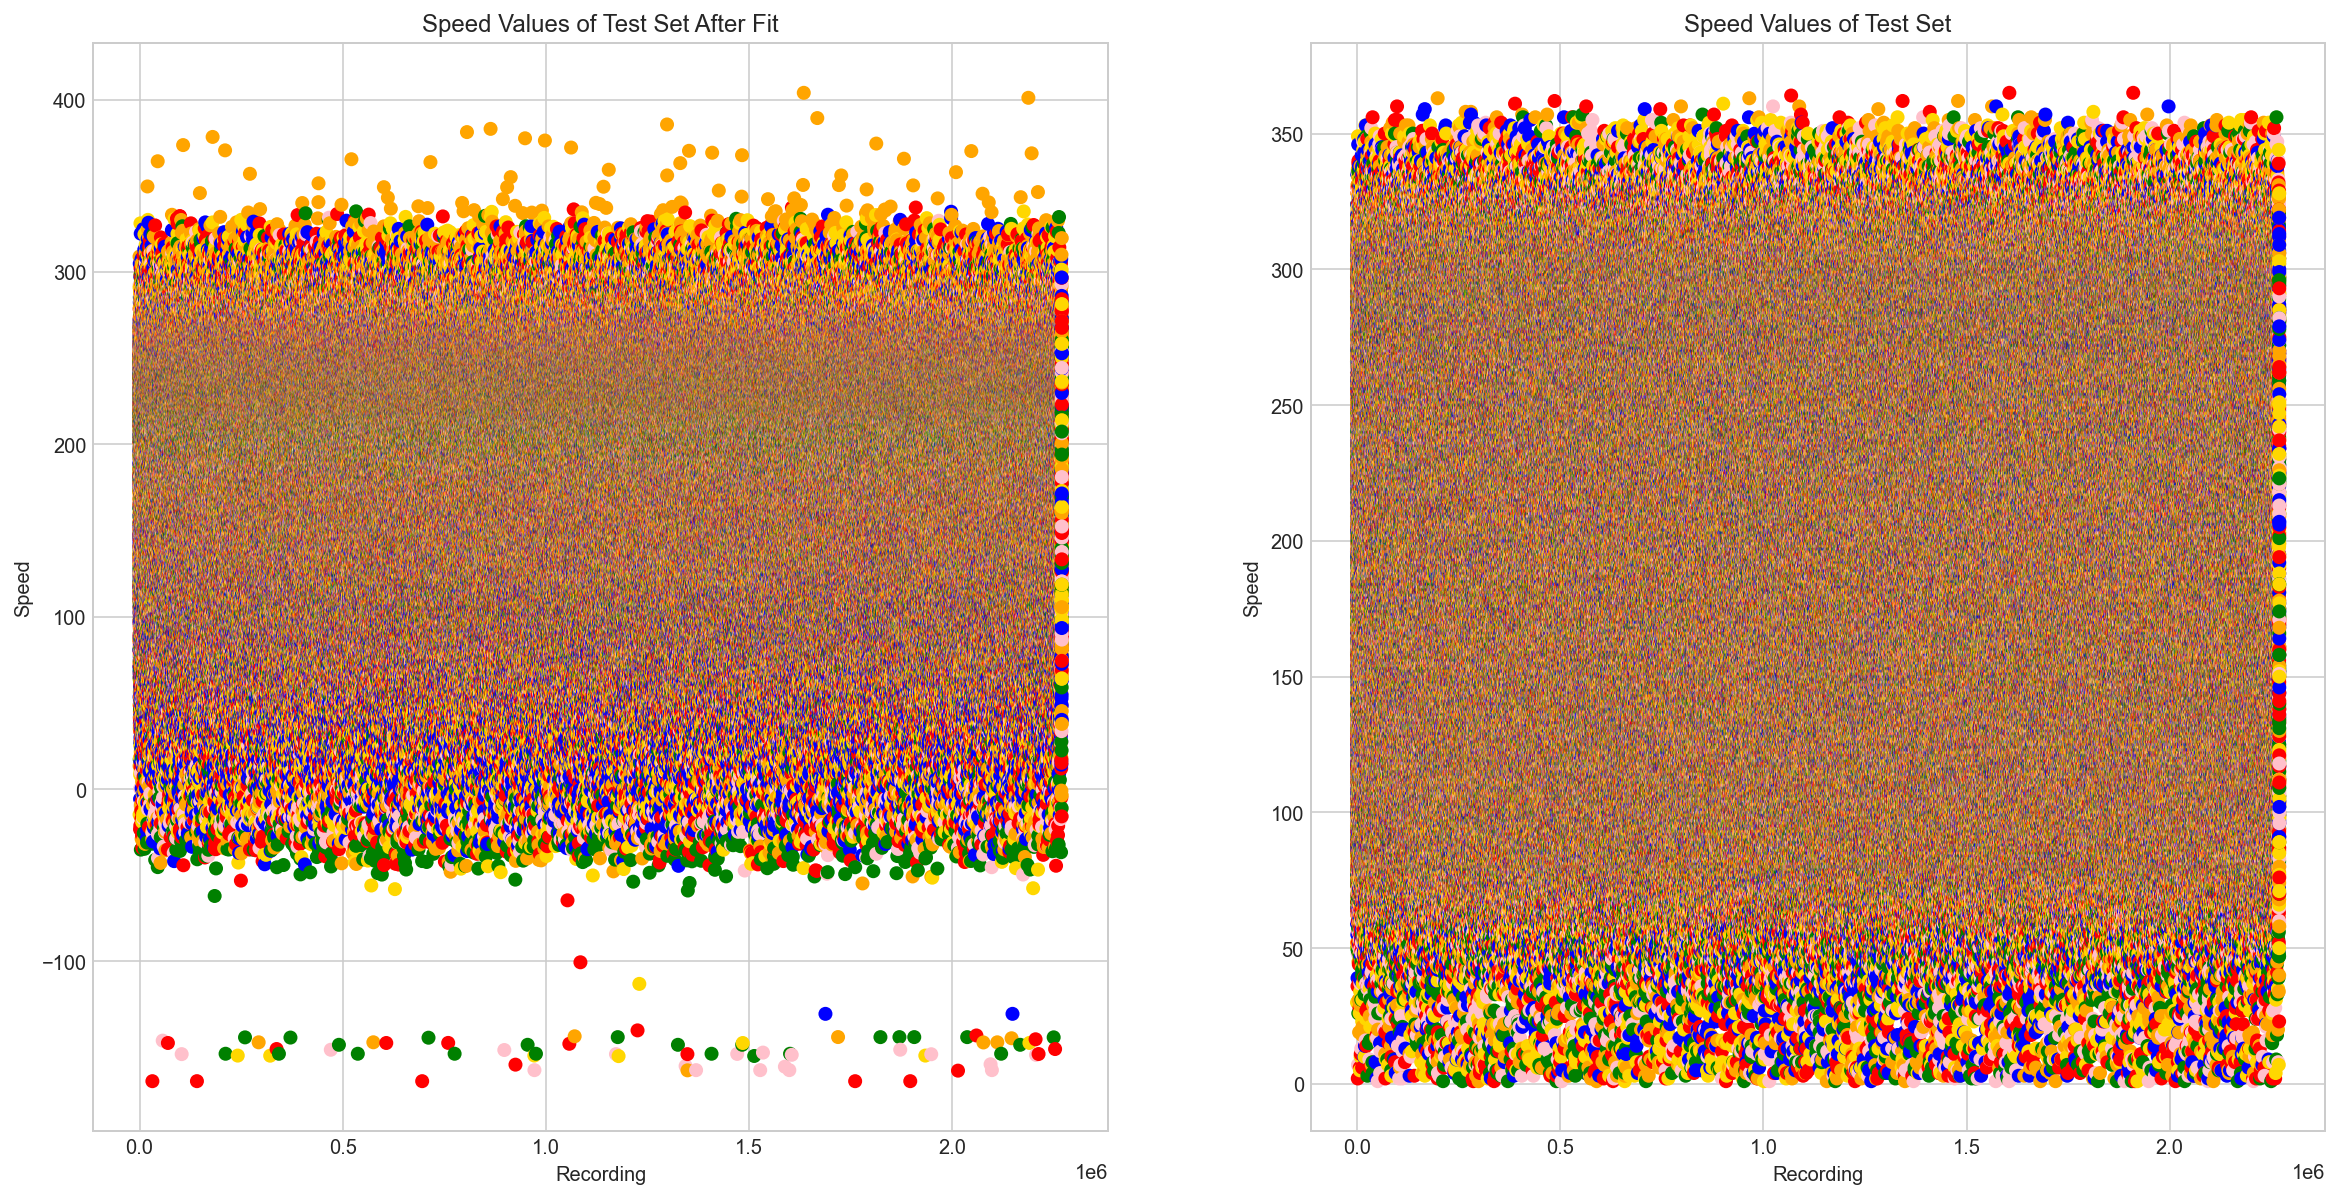

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
colors = ['blue','red','green','orange','pink','gold']
colormap = {drivers[i]: colors[i] for i in range(len(drivers))}
rlm_pred = results.predict(y_test)

ax[0].scatter(range(0,len(rlm_pred)), rlm_pred, c=rlm_pred.index.map(colormap))
ax[0].set_title('Speed Values of Test Set After Fit')
ax[0].set_ylabel('Speed')
ax[0].set_xlabel('Recording')

ax[1].scatter(range(0,len(X_test)), X_test, c=X_test.index.map(colormap))
ax[1].set_title('Speed Values of Test Set')
ax[1].set_ylabel('Speed')
ax[1].set_xlabel('Recording')

#ax[1,0].scatter(results.predict(y_test), results.predict(y_test).index)
#ax[1,1].scatter(X_test, X_test.index)

We can see that the regression is not very good at predicting lower speeds, especially since it goes into the negatives at times.

Text(0.5, 0, 'Parameter')

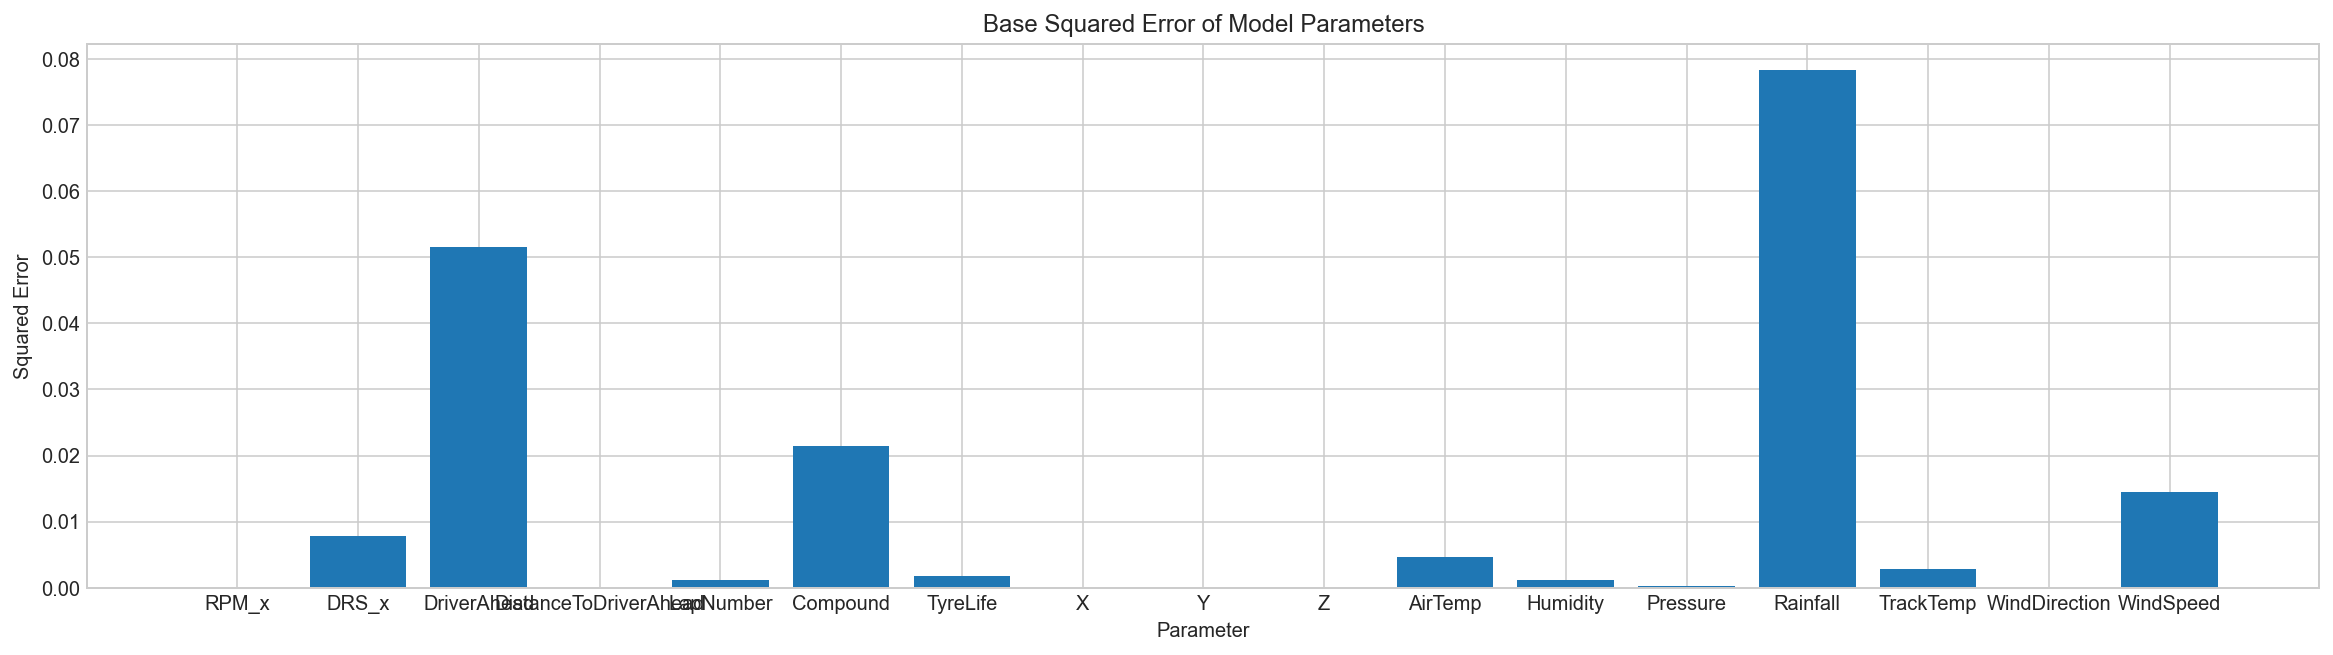

In [246]:
fig, ax = plt.subplots(figsize=(20,5))

ax.bar(results.bse.index, results.bse)
ax.set_title('Base Squared Error of Model Parameters')
ax.set_ylabel('Squared Error')
ax.set_xlabel('Parameter')

Interestingly, the existence of a driver ahead and the amount of rainfall have the highest error. This could be because a driver can go from being in the midfield all season to being a consistent race winner, and vice versa. Therefore, it may be useful to remove that column from the dataset. Rainfall, on the other hand, might have high error due to the fact that it can be a drastic determinant of pace during its occurence, but pace does not necessarily scale with the amount of rainfall on track.

Text(0.5, 0, 'Recording')

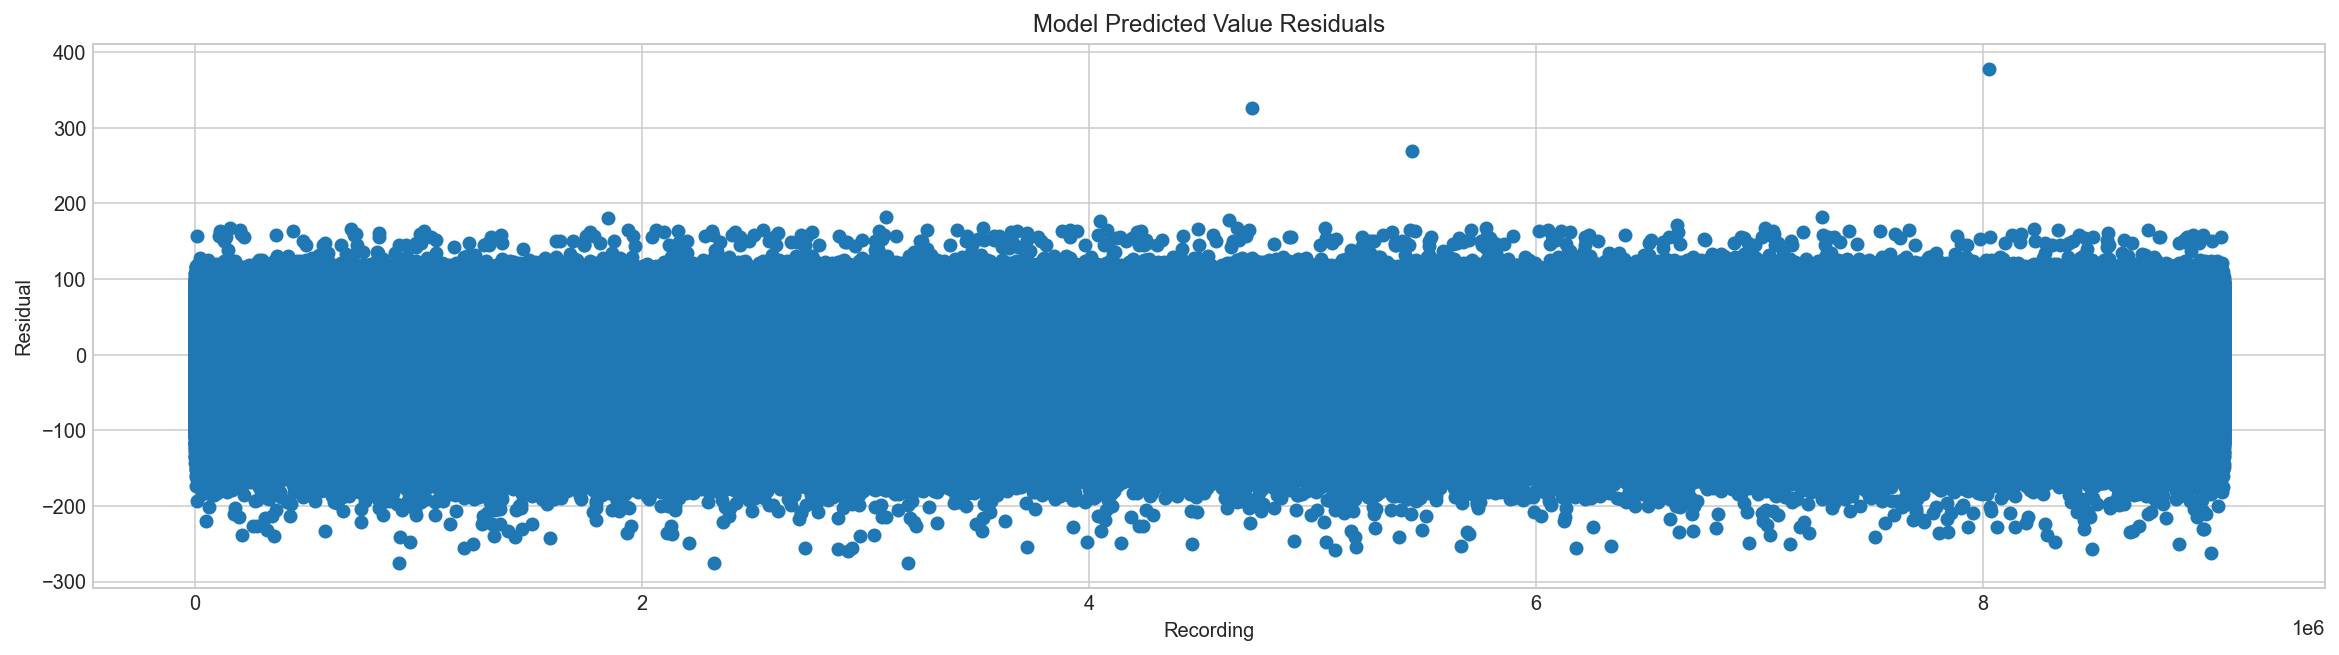

In [247]:
fig, ax = plt.subplots(figsize=(20,5))

ax.scatter(results.resid.reset_index().drop(0, axis=1).index, results.resid)
ax.set_title('Model Predicted Value Residuals')
ax.set_ylabel('Residual')
ax.set_xlabel('Recording')

The residuals do not have a trend or pattern, which means there is no heteroskedasticity in the residuals and variance.

#### Classifiers
Now let us see if we can predict the driving style based determinants of pace. We will do this in two different ways.

1) Predicting the actual driver

2) Predicting the driving style/type (cluster)

*Dataset variables*

data -> total concatenated dataframe

*K=3 Clusters*

Hamilton, Vettel | Verstappen, Ricciardo, Bottas | Perez

##### Decision Tree Classifier

We start first with predicting the actual driver

In [271]:
y = pd.Series(data.index, name='Driver')
x = data.reset_index().drop('Driver', axis=1)

x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5)
tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [272]:
y_pred = tree.predict(x_test)
y_pred = pd.Series(y_pred, index=x_test.index, name="PredictedDriver")
y_pred

6848129     RIC
3588088     RIC
10955177    RIC
10769300    PER
10422736    PER
           ... 
2446482     VET
10116882    PER
10160503    VET
10612519    PER
5036111     RIC
Name: PredictedDriver, Length: 2269440, dtype: object

In [274]:
x_test.join(y_test).join(y_pred)[y_test != y_pred]

Speed_x    RPM_x  DRS_x  DriverAhead  DistanceToDriverAhead  \
6848129     159.0   9890.0    0.0          1.0              74.808889   
3588088     151.0   9364.0    0.0          1.0             311.096389   
10955177    266.0   9476.0    0.0          1.0             140.658611   
10769300    229.0  11282.0    0.0          1.0             501.387500   
10422736    266.0  10934.0    0.0          1.0              63.427222   
...           ...      ...    ...          ...                    ...   
7279003      58.0   5632.0    1.0          1.0              29.479444   
10116882    328.0  11744.0    0.0          1.0              72.278889   
10160503     89.0   7712.0    1.0          1.0             727.070278   
10612519    150.0  11336.0    1.0          1.0             254.173333   
5036111     223.0  10193.0    0.0          1.0             562.515833   

          LapNumber  Compound  TyreLife        X        Y       Z  AirTemp  \
6848129        68.0       3.0      33.0  -6920.0  -5017.0   486.0     20.7   
3588088        23.0       3.0       4.0    694.0     98.0   145.0     21.0   
10955177       24.0       2.0       9.0  -1308.0  -5030.0   112.0     29.2   
10769300       44.0       3.0      22.0   7102.0   3340.0  2031.0     29.8   
10422736       23.0       2.0      15.0    370.0  -4001.0  3182.0     30.4   
...             ...       ...       ...      ...      ...     ...      ...   
7279003        33.0       2.0       3.0  -6027.0  -9669.0   490.0     22.0   
10116882       39.0       2.0      12.0  -1081.0   2412.0  1888.0     21.6   
10160503       28.0       2.0      31.0  -1099.0  -2743.0   230.0     22.3   
10612519       17.0       3.0      17.0 -13911.0 -10295.0   960.0     10.4   
5036111        21.0       1.0      24.0   8366.0   3361.0   557.0     22.0   

          Humidity  Pressure  Rainfall  TrackTemp  WindDirection  WindSpeed  \
6848129       60.4    1015.8       0.0       33.7          175.0        0.4   
3588088       27.0    1012.2       0.0       41.7           14.0        5.6   
10955177      75.8    1014.0       0.0       31.7          231.0        0.3   
10769300      37.1    1006.6       0.0       49.2          331.0        0.2   
10422736      39.5     993.6       0.0       43.5          321.0        1.1   
...            ...       ...       ...        ...            ...        ...   
7279003       73.0    1003.2       0.0       28.6          186.0        0.4   
10116882      50.2     989.0       0.0       31.8          214.0        2.0   
10160503      66.9    1016.9       0.0       34.4          237.0        1.9   
10612519      67.7    1011.1       0.0       14.0           88.0        0.6   
5036111       53.5    1021.5       0.0       37.0           44.0        0.4   

         Driver PredictedDriver  
6848129     PER             RIC  
3588088     VET             RIC  
10955177    BOT             RIC  
10769300    BOT             PER  
10422736    BOT             PER  
...         ...             ...  
7279003     PER             HAM  
10116882    BOT             PER  
10160503    BOT             VET  
10612519    BOT             PER  
5036111     VER             RIC  

[1674158 rows x 20 columns]

<AxesSubplot: >

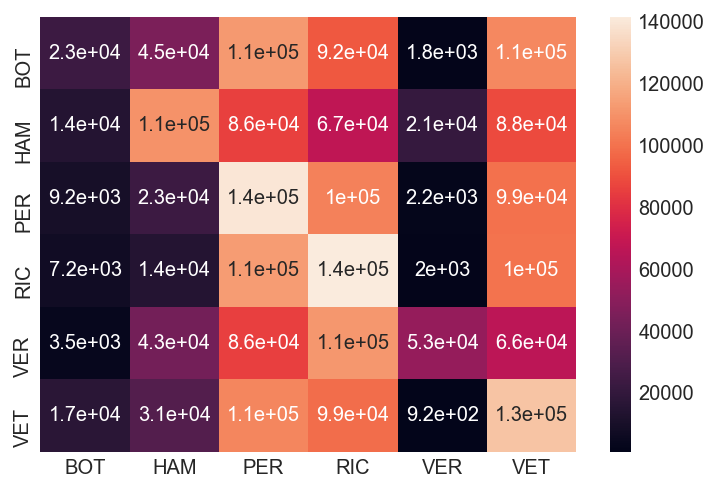

In [275]:
c = confusion_matrix(y_test, y_pred, labels=tree.classes_)
c = pd.DataFrame(c, index=tree.classes_, columns=tree.classes_)
sns.heatmap(c, annot=True)

In [276]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         BOT       0.32      0.06      0.10    382038
         HAM       0.41      0.28      0.34    386940
         PER       0.22      0.37      0.27    378677
         RIC       0.23      0.37      0.28    378241
         VER       0.66      0.15      0.24    362829
         VET       0.22      0.33      0.26    380715

    accuracy                           0.26   2269440
   macro avg       0.34      0.26      0.25   2269440
weighted avg       0.34      0.26      0.25   2269440



Now we will try to classify the clusters.

In [277]:
y = pd.Series([0 if i=='HAM' or i=='VET' else 1 if i=='VER' or i=='RIC' or i=='BOT' else 2 for i in data.index],
             name = 'Cluster')
x = data.reset_index().drop(['Driver'], axis=1)

x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5)
tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [278]:
y_pred = tree.predict(x_test)
y_pred = pd.Series(y_pred, index=x_test.index, name="PredictedCluster")
y_pred

6848129     1
3588088     1
10955177    1
10769300    1
10422736    1
           ..
2446482     0
10116882    1
10160503    1
10612519    1
5036111     1
Name: PredictedCluster, Length: 2269440, dtype: int64

In [279]:
x_test.join(y_test).join(dt_pred)[y_test != y_pred]

Speed_x    RPM_x  DRS_x  DriverAhead  DistanceToDriverAhead  \
6848129     159.0   9890.0    0.0          1.0              74.808889   
3588088     151.0   9364.0    0.0          1.0             311.096389   
6943999     290.0  10523.0    0.0          1.0             676.518056   
5898826     280.0  11363.0   12.0          1.0             198.899722   
2443250     262.0  11827.0    0.0          1.0             792.413611   
...           ...      ...    ...          ...                    ...   
10719044    224.0  12388.0    0.0          1.0             223.985000   
2578172     262.0  11904.0    0.0          1.0             916.125278   
731505      279.0  11395.0    0.0          1.0             248.141389   
2682961     111.0   8194.0    0.0          1.0              26.381944   
7279003      58.0   5632.0    1.0          1.0              29.479444   

          LapNumber  Compound  TyreLife        X        Y       Z  AirTemp  \
6848129        68.0       3.0      33.0  -6920.0  -5017.0   486.0     20.7   
3588088        23.0       3.0       4.0    694.0     98.0   145.0     21.0   
6943999        22.0       2.0       4.0   7526.0   7091.0  2057.0     30.1   
5898826        16.0       3.0      18.0  -3670.0    335.0   187.0     30.1   
2443250        30.0       3.0       4.0  -2434.0   6199.0   159.0     29.6   
...             ...       ...       ...      ...      ...     ...      ...   
10719044       16.0       2.0      19.0  -2337.0   1463.0  7352.0     27.1   
2578172        35.0       1.0       6.0   5651.0 -12403.0  4199.0     17.6   
731505          8.0       1.0      11.0 -10407.0     76.0   899.0     21.4   
2682961        33.0       2.0       8.0  -3145.0    786.0  7587.0     21.2   
7279003        33.0       2.0       3.0  -6027.0  -9669.0   490.0     22.0   

          Humidity  Pressure  Rainfall  TrackTemp  WindDirection  WindSpeed  \
6848129       60.4    1015.8       0.0       33.7          175.0        0.4   
3588088       27.0    1012.2       0.0       41.7           14.0        5.6   
6943999       36.4    1007.0       0.0       50.5          339.0        0.2   
5898826       64.3    1007.9       0.0       33.6          178.0        1.8   
2443250       16.1    1022.2       0.0       50.6          283.0        1.2   
...            ...       ...       ...        ...            ...        ...   
10719044      32.0     938.5       0.0       53.9          164.0        0.3   
2578172       56.0     968.3       0.0       27.8            3.0        2.7   
731505        57.5    1008.7       0.0       32.3          286.0        6.2   
2682961       59.3     924.6       0.0       47.4          170.0        0.8   
7279003       73.0    1003.2       0.0       28.6          186.0        0.4   

          Cluster  PredictedCluster  
6848129         2               NaN  
3588088         0               NaN  
6943999         2               NaN  
5898826         2               NaN  
2443250         0               NaN  
...           ...               ...  
10719044        1               NaN  
2578172         0               NaN  
731505          0               1.0  
2682961         0               NaN  
7279003         2               NaN  

[1082081 rows x 20 columns]

<AxesSubplot: >

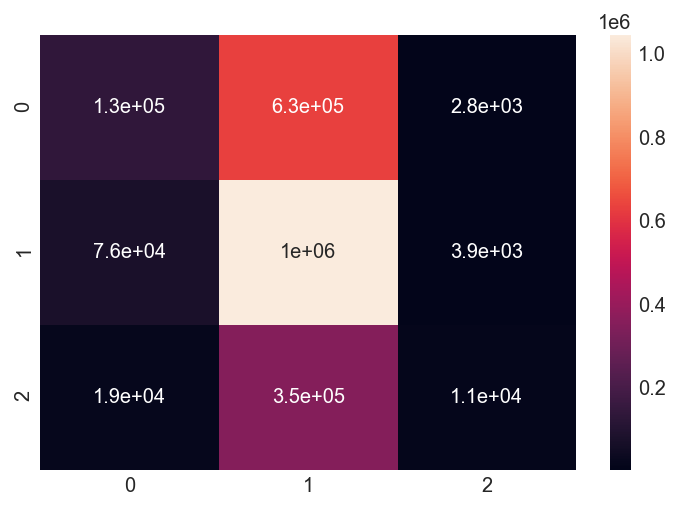

In [280]:
c = confusion_matrix(y_test, y_pred, labels=tree.classes_)
c = pd.DataFrame(c, index=tree.classes_, columns=tree.classes_)
sns.heatmap(c, annot=True)

In [281]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.17      0.27    767655
           1       0.52      0.93      0.66   1123108
           2       0.62      0.03      0.06    378677

    accuracy                           0.52   2269440
   macro avg       0.57      0.38      0.33   2269440
weighted avg       0.56      0.52      0.43   2269440



It is clear based on the model results that the decision tree classifier has an easier time classifying the data into the clusters than the drivers. When classifying into clusters, it is also about 91% accurate, as around 9% of the datset has been missclassified.

## Conclusion
Do some drivers share a similar driving style, and how can that be determined?
- It seems that it is entirely possible to determine driving style/type based on the car measurements, telemetry, and weather. Though there was potentially an issue with including drivers that consitently win, this seems to have been reduced (if this would have had an impact, Verstappen and Hamilton would be in the same cluster). 
- Based on the distance data, Hamilton and Vettel are incredibly close, while Verstappen, Ricciardo, and Bottas have a similar closeness. That leaves Perez as an outlier.
- This theory is backed up by both forms of dimension reduction. Both MDS and PCA yield similar cluster results. 
- Interestingly, the 3D visualizations place Perez closer to Hamilton and Vettel than initially thought.
- In predicting the clusters with classification, the decision tree algorithm struggles slightly. This could be because we included weather data, something which the driver cannot control.

Can driver pace be determined by circumstantial factors?
- The regression results indicate that the existence of a driver ahead, and the level of rainfall are the greatest determinants of pace. This makes sense practically, as a driver ahead would be generating dirty air, and rainfall inherently slows down pace due to friction and safety.
- There is no pattern in the residuals, meaning the regression was conducted correctly, though the algorithm has a hard time with lower speeds. The amount of negative predictions backs this up, despite the high model scores.
- There is a high amount of mean squared error with the highest predictors, unsurprisingly, due to their sheer deterministic nature.
- It is entirely possible to determine pace from car measurements, telemetry, and weather.

Impacts
- In the construction and maintenance of circuits, as well as the writing of new regulations, the FIA is constantly looking for ways to even the playing field. If there are a high number of drivers who utilize a single driving style, the FIA can change circuits and regulations to assist the minority. 
- Additionally, teams that specialize their car to their driver's style, be it different from others, can prevent stolen or leaked mechanical information from being properly utilized by a rival team.
- Knowing how similar in driving style both drivers from a single team are is also useful in car development, since a team with two drivers of similar style have to spend less money specializing both cars.
- As for knowing pace, this is incredibly important in making adjustments to compensate for circumstantial factors both before and during races. A team that is aware of how these factors affect their drivers pace can compensate accordingly.
- This goes both ways as well, since a team that knows how these factors affect rival drivers will have the upper hand against other teams.

Caveats
- This analysis could be improved by using slightly different datasets for each sub-analysis. 
- For example, driving style classification might be improved by removing factors that the driver cannot control, such as weather.
- Also, analysis should have been done on all drivers on the grid in the last five years, instead of only six. 
- Tuning hyperparameters would also help with analysis, as parameters are currently inferred after running the algorithm multiple times.

Future
- We should investigate other factors and metrics, and how they might impact these two questions.
- As mentioned previously, adjusting the amount of metrics being used in each algorithm should be done to prevent missifitting the data.
- Interesting future work may also be to gather geospatial and elevation data on each circuit to determine how this affects each car and driver, as well as researching whether a driver's style cluster changes based on the aforementioned factors.